In [23]:
#Import required packages
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim

from torch.autograd import grad
from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint
import pandas as pd

In [103]:
def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)

def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

#Custom loss function
def loss_fun(pred, alpha=1E7):
    """Computes scalarized loss including genetic constraint and product production"""
    j1 = pred[-1][-2]
    j2 = pred[-1][-1]
    loss = j1 + alpha*j2
    return loss

class DualControl(torch.nn.Module):
    def __init__(self):
        super(DualControl, self).__init__()
        #Initialize constants, taken from Verma et al paper.
        self.Vin = 1.
        self.e0 = 0.0467
        self.lam = 1.93E-4 #1/s
        #Assume equal kinetics for all three enzymes
        self.kc = 12
        self.km = 10 #1/s

        self.W = torch.nn.Parameter(torch.tensor([[2,2],[1,1], [1E-5, 1E-5]]), requires_grad=True)
        

    def forward(self, t, y):
        '''Computes derivatives of system of differential equations'''
        dx0 = self.Vin - self.lam*y[0] - self.e0*nonlinearity(y[0], self.kc, self.km) - self.lam*y[1]
        dx1 = y[2]*nonlinearity(y[0], self.kc, self.km) - y[3]*nonlinearity(y[1], self.kc, self.km) - self.lam*y[1]
        de1 = repression(y[1], self.W[2][0], self.W[1][0], self.W[0][0]) - self.lam*y[2]
        de2 = activation(y[1], self.W[2][1], self.W[1][1], self.W[0][1]) - self.lam*y[3]
        j1 = (self.Vin -  y[3]*nonlinearity(y[1], self.kc, self.km))**2
        j2 = repression(y[1], self.W[2][0], self.W[1][0], self.W[0][0]) + activation(y[1], self.W[2][1], self.W[1][1], self.W[0][1])
        return torch.stack([dx0, dx1, de1, de2, j1, j2])

class ODEFun(torch.nn.Module):
    def __init__(self):
        super(ODEFun, self).__init__()
        self.W = torch.nn.Parameter(torch.tensor([0.0, 0.0]), requires_grad=True)
        
    def forward(self, t, y):
        S, I = y
        ds = -self.W[0]*S*I
        di = self.W[1]*S*I - I
        return torch.stack([ds, di])

func = DualControl()
learning_rate = 0.01
num_iters = 100
optimizer = optim.Adam(func.parameters(), amsgrad=False, lr=learning_rate)
adjoint = False
alpha = 1E7
solver = 'dopri8'

np.random.seed(2021)
# torch.manual_seed(2021)
plt.close('all')

#Establish initial conditions
t = torch.linspace(0, 5E4, 100) 
y0 = torch.tensor([2290., 0., 0., 0., 0., 0.]) 


In [100]:
pred = odeint(func, y0, t, method=solver)

In [104]:
pred = odeint_adjoint(func, y0, t, method=solver)

Text(0, 0.5, 'Concentrations')

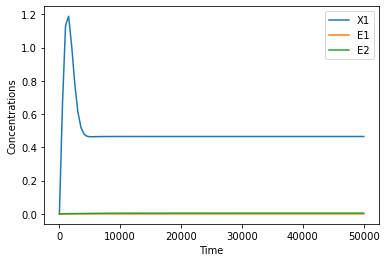

In [85]:
sol1 = pred.detach().numpy()
#plt.plot(t, sol1[:, 0], label='X0')
plt.plot(t, sol1[:, 1], label='X1')
plt.plot(t, sol1[:, 2], label='E1')
plt.plot(t, sol1[:, 3], label='E2')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentrations')

In [86]:
loss = loss_fun(pred, alpha = alpha)
print(func.W.grad)
loss.backward()
print(func.W.grad)
optimizer.step()

None
tensor([[-3.1112e+04,  3.1224e+04],
        [ 4.0815e+05, -4.0962e+05],
        [ 2.2439e+10,  4.7732e+11]])
